# Pre-processing SRCNN 

In [1]:
from data import DIV2K
train = DIV2K(scale=4, downgrade='bicubic', subset='train')
train_ds = train.dataset(batch_size=16, random_transform=True)

In [2]:
# Baseline srcnn
from PIL import Image
from PIL import ImageFilter
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Add, Conv2D, Input, Lambda, UpSampling2D
from tensorflow.keras.models import Model
import cv2
from tensorflow.keras.preprocessing.image import save_img
DIV2K_RGB_MEAN = np.array([0.4488, 0.4371, 0.4040]) * 255

def srcnn():
    '''
    creates a srcnn model with post_sampling
    '''
    x_in = Input(shape=(None, None, 3))
    x = (x_in - DIV2K_RGB_MEAN) / 127.5 # normalize
    x = UpSampling2D(size=(4, 4), interpolation = 'bilinear')(x)
    
    
    kernel = np.array([[-1,-1,-1],[-1,9,-1],[-1,-1,-1]])
    kernel = tf.constant(kernel,dtype=tf.float32)
    kernel = kernel[:,:,tf.newaxis,tf.newaxis]
    
    sr0 = tf.nn.conv2d(x[:,:,:,0:1],kernel, strides = [1,1,1,1], padding = 'SAME')
    sr1 = tf.nn.conv2d(x[:,:,:,1:2],kernel, strides = [1,1,1,1], padding = 'SAME')
    sr2 = tf.nn.conv2d(x[:,:,:,2:3],kernel, strides = [1,1,1,1], padding = 'SAME')
    x = tf.concat([sr0,sr1,sr2],axis=-1)    
    
    x = Conv2D(64, 9, padding='same', activation='relu')(x)
    x = Conv2D(32, 5, padding='same', activation='relu')(x)
    x = Conv2D(3, 5, padding='same')(x)
    
    x = x * 127.5 + DIV2K_RGB_MEAN # denormalize
    return Model(x_in, x, name="srcnn")


In [4]:
model = srcnn()

In [5]:
import os
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay
from tensorflow.python.keras.models import Model

# Adam optimizer with a scheduler that halfs learning rate after 20,000 steps
optim_srcnn = Adam(learning_rate=PiecewiseConstantDecay(boundaries=[20000,50000], values=[1e-4, 5e-5,1e-5]))

# Compile and train model for 300,000 steps with L1 pixel loss
model.compile(optimizer=optim_srcnn, loss='mean_squared_error')
model.fit(train_ds, epochs=100, steps_per_epoch=1000)

# Save model weights
weights_dir = 'weights/'
model.save_weights(os.path.join(weights_dir, 'weights-srcnn-filter-mse-x4.h5'))

Epoch 1/100
1000/1000 [==============================] - 59s 59ms/step - loss: 297.5232
Epoch 2/100
1000/1000 [==============================] - 59s 59ms/step - loss: 208.8249
Epoch 3/100
1000/1000 [==============================] - 59s 59ms/step - loss: 204.0935
Epoch 4/100
1000/1000 [==============================] - 59s 59ms/step - loss: 196.5953
Epoch 5/100
1000/1000 [==============================] - 59s 59ms/step - loss: 194.2332
Epoch 6/100
1000/1000 [==============================] - 59s 59ms/step - loss: 195.7146
Epoch 7/100
1000/1000 [==============================] - 59s 59ms/step - loss: 192.5657
Epoch 8/100
1000/1000 [==============================] - 59s 59ms/step - loss: 191.1038
Epoch 9/100
1000/1000 [==============================] - 59s 59ms/step - loss: 191.6088
Epoch 10/100
1000/1000 [==============================] - 59s 59ms/step - loss: 187.9985
Epoch 11/100
1000/1000 [==============================] - 59s 59ms/step - loss: 190.0717
Epoch 12/100
1000/1000 [======

In [3]:
import os
weights_dir = 'weights'

model = srcnn()
model.load_weights(os.path.join(weights_dir, 'weights-srcnn-filter-mse-x4.h5'))

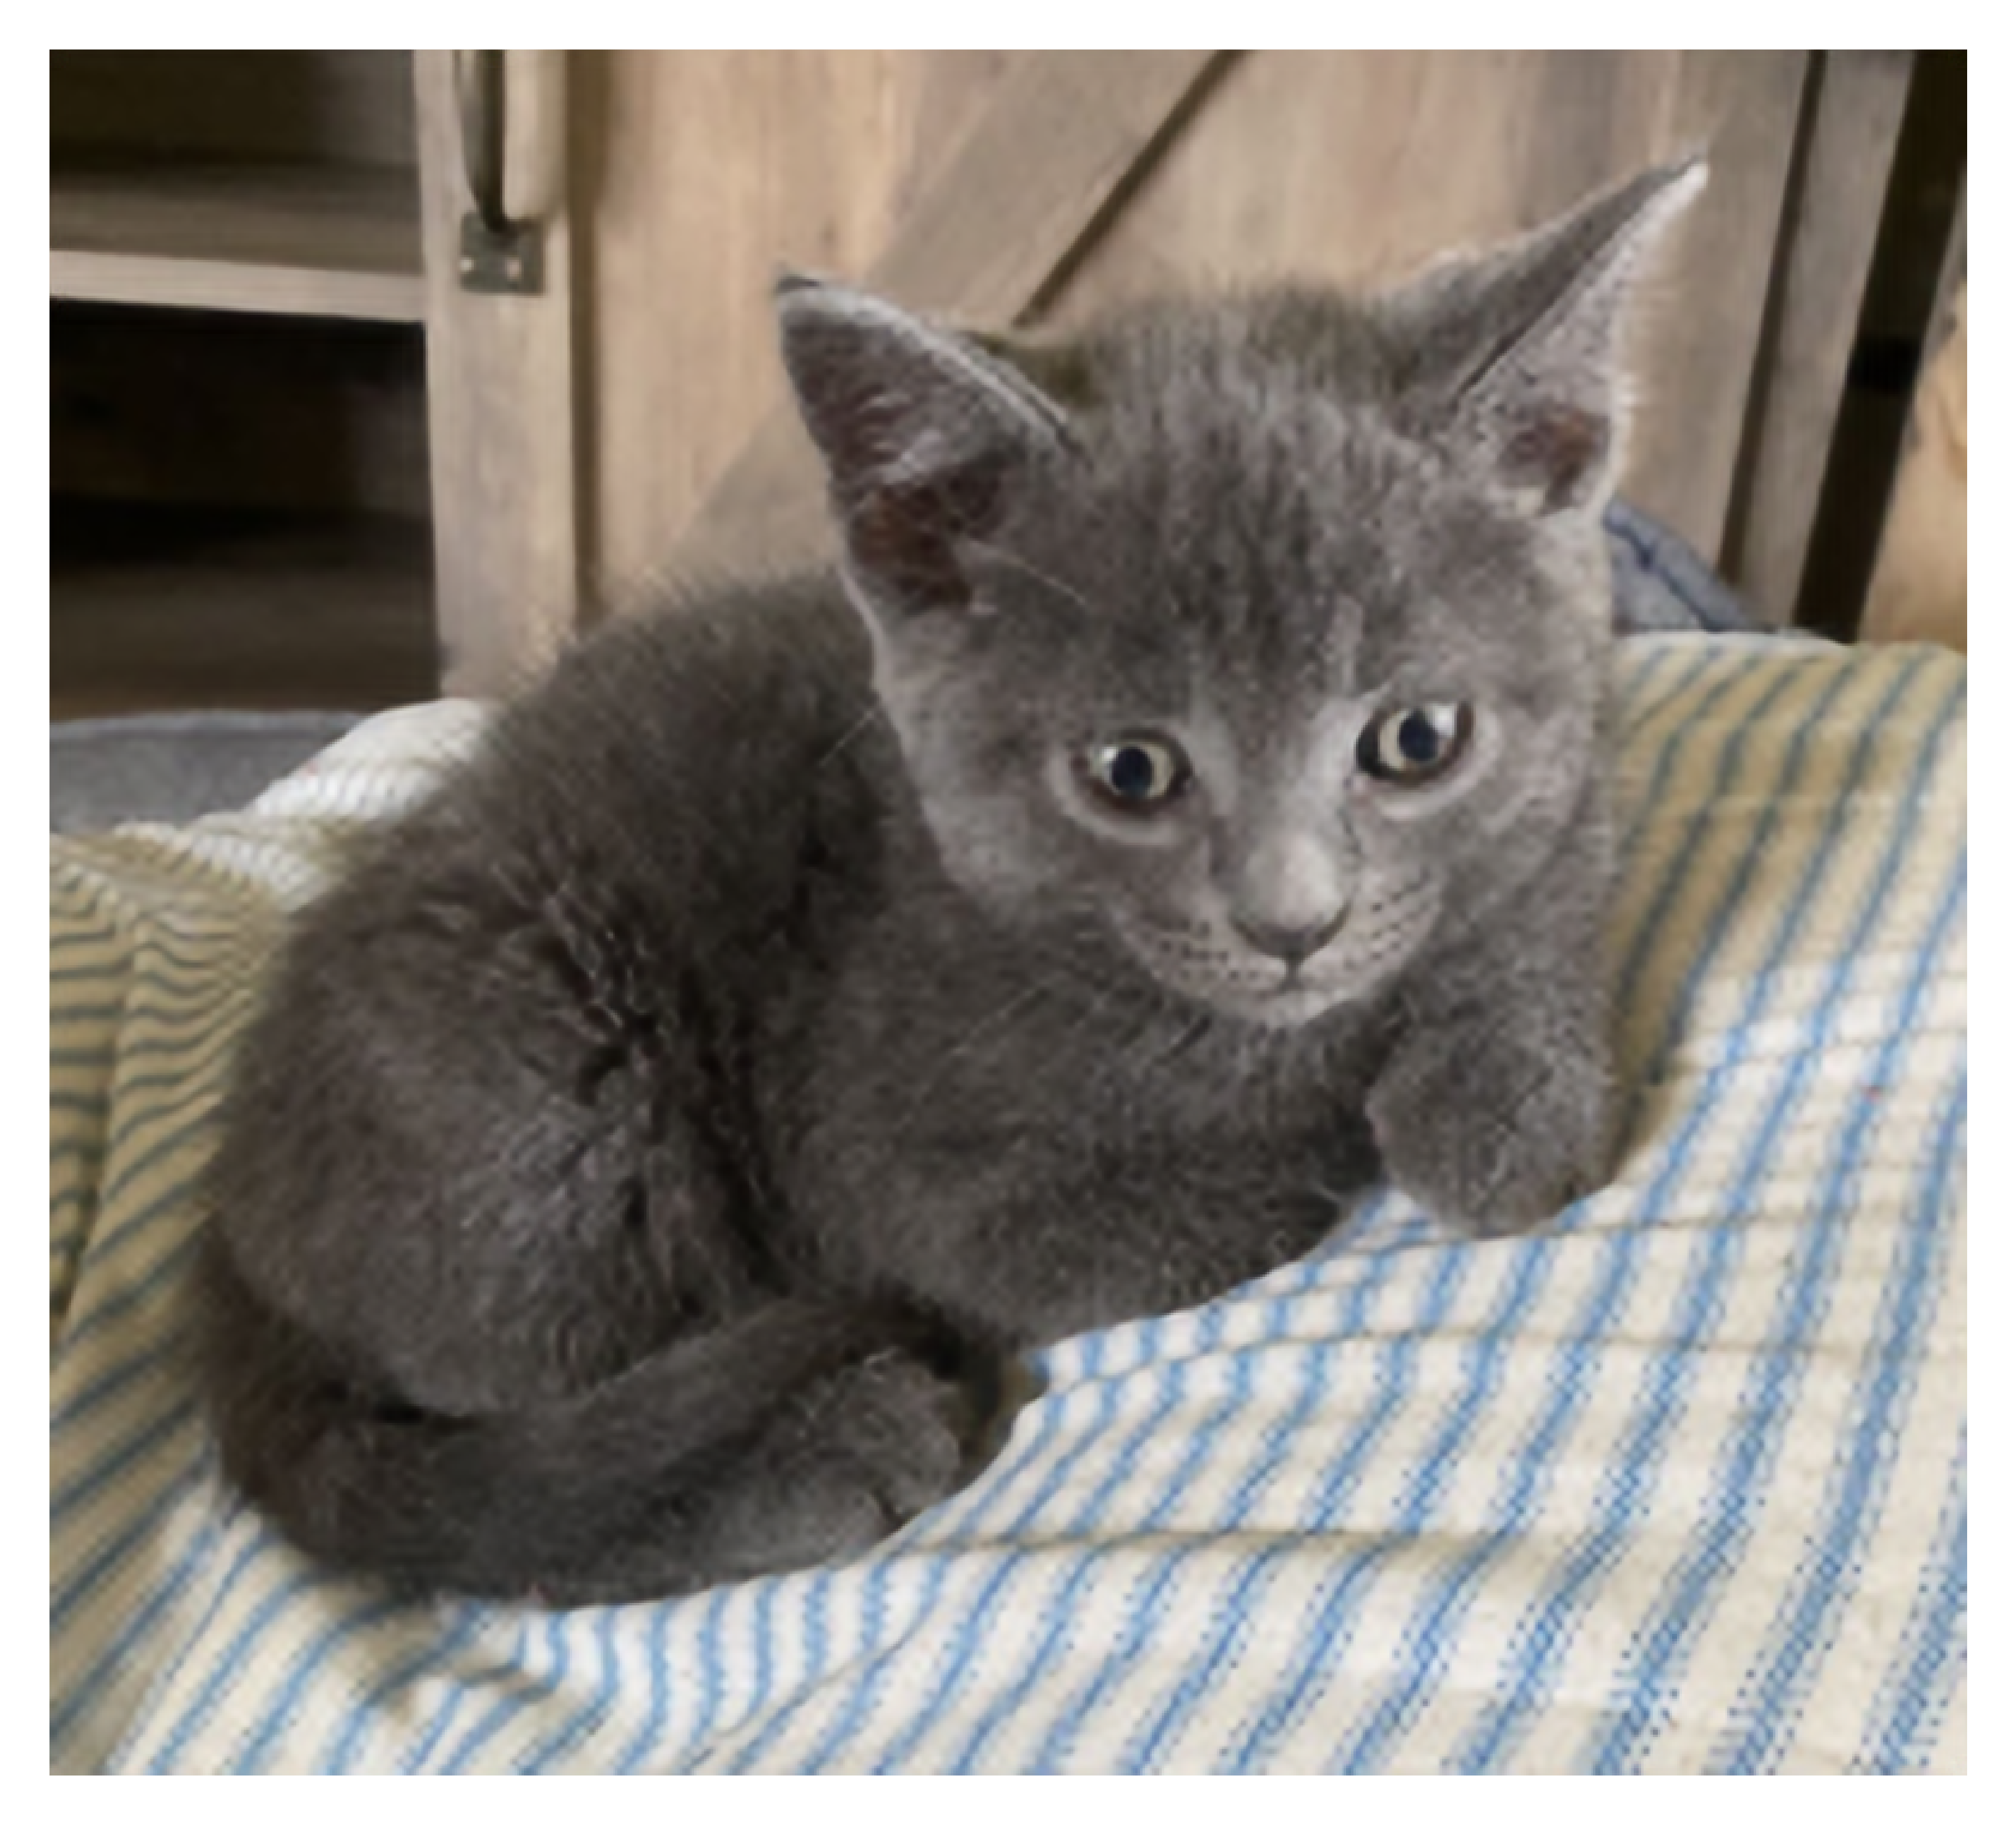

In [4]:
from utils import load_image
from matplotlib import pyplot as plt

import numpy as np
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
from tensorflow.keras.preprocessing.image import save_img

def resolve_single(model, lr):
    return resolve(model, tf.expand_dims(lr, axis=0))[0]
def resolve(model, lr_batch):
    lr_batch = tf.cast(lr_batch, tf.float32)
    sr_batch = model(lr_batch)
    sr_batch = tf.clip_by_value(sr_batch, 0, 255)
    sr_batch = tf.round(sr_batch)
    sr_batch = tf.cast(sr_batch, tf.uint8)
    return sr_batch
#resolve_and_plot('demo/0851x4-crop.png')
# hr = load_image('bird_hr.png')[:,:,:3]
# hr = rescale(hr,1,multichannel=True)
# hr = hr[0:1000,200:1100,:]
# hr = np.transpose(hr,(1,0,2))

lr = load_image('test.png')
sr0 = resolve_single(model, lr)


fig,ax = plt.subplots(1,1,dpi=800,figsize=(5,5))
ax.axis('off')
ax.imshow(sr0)
fig.savefig('0.png')

In [5]:
from PIL import Image
from PIL import ImageFilter
imageObject = Image.open("test.png")
edgeEnahnced = imageObject.filter(ImageFilter.EDGE_ENHANCE)
# for i in range(1):
#     edgeEnahnced = edgeEnahnced.filter(ImageFilter.EDGE_ENHANCE)
moreEdgeEnahnced = imageObject.filter(ImageFilter.EDGE_ENHANCE_MORE)
imageObject.show() 
edgeEnahnced.save("test_en.png")

In [6]:
en= load_image('test_en.png')